### Analyze Auto sales trend and verify if RCF detects abrupt shift in sales
#### Years: 2005 to 2020.  This period covers recession due to housing crisis in 2008, followed by recovery and economic impact due to Covid
### Data Source:
Monthly New Vehicle Sales for the United States Automotive Market: https://www.goodcarbadcar.net/usa-auto-industry-total-sales-figures/<br>
Raw data: http://www.bea.gov/<br>

This script is based on AWS SageMaker Examples for Random Cut Forest: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/random_cut_forest/random_cut_forest.ipynb

In [1]:
import sys
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

In [2]:
import boto3
import botocore
import sagemaker

bucket = sagemaker.Session().default_bucket()   # Feel free to change to another bucket you have access to
prefix = 'sagemaker/autosales'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://sagemaker-us-east-1-144943967277/sagemaker/autosales


In [3]:
%%time
data_filename = 'auto_sales_year_month.csv'
df = pd.read_csv(data_filename)

CPU times: user 4.77 ms, sys: 76 µs, total: 4.84 ms
Wall time: 4.4 ms


In [4]:
df.shape

(188, 2)

In [5]:
df

,timestamp,value
0,2005-01-01,1052224.0
1,2005-02-01,1244753.0
2,2005-03-01,1564938.0
3,2005-04-01,1493837.0
4,2005-05-01,1488171.0
...,...,...
183,2020-04-01,563122.0
184,2020-05-01,1181756.0
185,2020-06-01,1214706.0
186,2020-07-01,481587.0


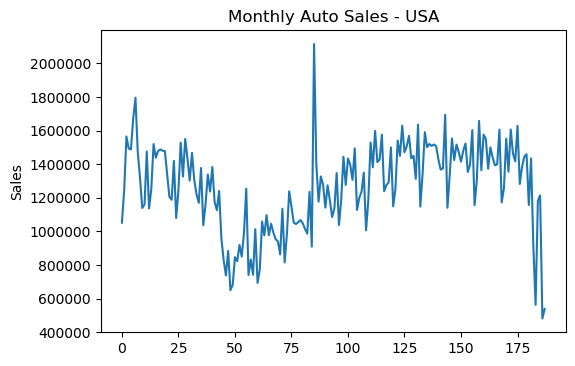

In [6]:
plt.plot(df['value'])
plt.ylabel('Sales')
plt.title('Monthly Auto Sales - USA')
plt.show()

### Big increase in autosales Feb-2012
https://www.theautochannel.com/news/2012/03/02/027504-february-2012-u-s-auto-sales-highest-4-years.html

In [7]:
df[75:90]

,timestamp,value
75,2011-04-01,1149240.0
76,2011-05-01,1052417.0
77,2011-06-01,1044037.0
78,2011-07-01,1055231.0
79,2011-08-01,1067895.0
80,2011-09-01,1048158.0
81,2011-10-01,1015016.0
82,2011-11-01,986664.0
83,2011-12-01,1236129.0
84,2012-01-01,909806.0


### U.S. Auto Sales Hit Record Low In April 2020
####  Coronavirus Chaos Also Drives Zero-Interest Deals to Record Highs
https://www.edmunds.com/car-news/us-auto-sales-hit-record-low-in-april.html

In [8]:
df[175:]

,timestamp,value
175,2019-08-01,1628577.0
176,2019-09-01,1282712.0
177,2019-10-01,1384010.0
178,2019-11-01,1445173.0
179,2019-12-01,1459164.0
180,2020-01-01,1157415.0
181,2020-02-01,1434716.0
182,2020-03-01,912800.0
183,2020-04-01,563122.0
184,2020-05-01,1181756.0


# Training

***

Next, we configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the taxi cab data.

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.m4`, `ml.c4`, or `ml.c5`
* Current limitations:
  * The RCF algorithm does not take advantage of GPU hardware.

In [9]:
# SDK 2.0
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
# 48 samples = 48 Months of data 
rcf = RandomCutForest(role=execution_role,
                      instance_count=1,
                      instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=48,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(df.value.to_numpy().reshape(-1,1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-20 03:11:05 Starting - Starting the training job...
2020-11-20 03:11:08 Starting - Launching requested ML instances.........
2020-11-20 03:12:44 Starting - Preparing the instances for training...................................................
2020-11-20 03:21:31 Downloading - Downloading input data
2020-11-20 03:21:31 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[11/20/2020 03:21:56 INFO 139642703619904] Reading default configurat


2020-11-20 03:21:58 Uploading - Uploading generated training model
2020-11-20 03:22:17 Completed - Training job completed
Training seconds: 59
Billable seconds: 59


In [10]:
rcf.hyperparameters()

{'num_samples_per_tree': '48',
 'num_trees': '50',
 'feature_dim': '1',
 'mini_batch_size': '1000'}

In [11]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2020-11-20-03-11-04-860


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [12]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------------------!

Congratulations! You now have a functioning SageMaker RCF inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [14]:
# SDK 2 endpoint_name
print('Endpoint name: {}'.format(rcf_inference.endpoint_name))

Endpoint name: randomcutforest-2020-11-20-03-25-52-508


## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [15]:
# SDK 2.0 serializers
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [16]:
df_numpy = df.value.to_numpy().reshape(-1,1)
print(df_numpy[:6])
results = rcf_inference.predict(df_numpy[:6])
print(results)

[[1052224.]
 [1244753.]
 [1564938.]
 [1493837.]
 [1488171.]
 [1671401.]]
{'scores': [{'score': 0.9632087828}, {'score': 0.905505851}, {'score': 1.0679756827}, {'score': 0.952731262}, {'score': 0.9467011764}, {'score': 1.1764848699}]}


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [17]:
results = rcf_inference.predict(df_numpy)
scores = [datum['score'] for datum in results['scores']]

In [18]:
import numpy as np

In [19]:
# Save the scores
np.savetxt("scores_individual_data_point.csv",
           np.asarray(scores),
           delimiter=",",
           fmt='%10.5f')

In [20]:
# add scores to taxi data frame and print first few values
df['score'] = pd.Series(scores, index=df.index)
df.head()

,timestamp,value,score
0,2005-01-01,1052224.0,0.963209
1,2005-02-01,1244753.0,0.905506
2,2005-03-01,1564938.0,1.067976
3,2005-04-01,1493837.0,0.952731
4,2005-05-01,1488171.0,0.946701


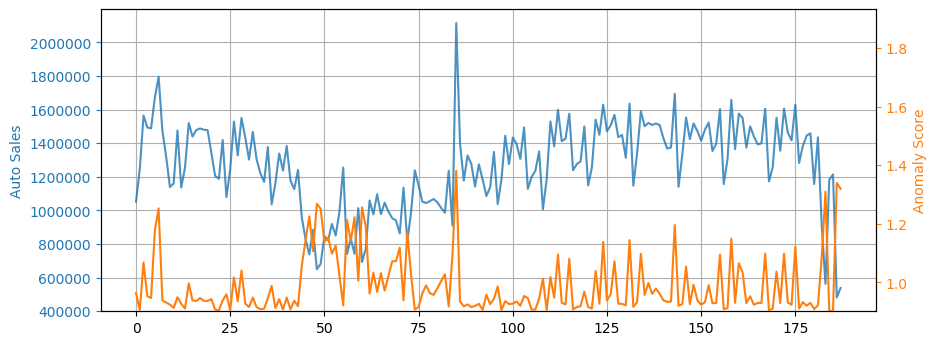

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df)

df_subset = df[start:end]

ax1.plot(df_subset['value'], color='C0', alpha=0.8)
ax2.plot(df_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Auto Sales', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 3 standard deviations (approx 99.9th percentile) from the mean score.

In [22]:
score_mean = df['score'].mean()
score_std = df['score'].std()
score_cutoff = score_mean + 2.0*score_std

anomalies = df_subset[df_subset['score'] > score_cutoff]
anomalies

,timestamp,value,score
6,2005-07-01,1795944.0,1.252665
46,2008-11-01,737978.0,1.225025
48,2009-01-01,650608.0,1.268405
49,2009-02-01,681676.0,1.251550
56,2009-09-01,740394.0,1.212953
58,2009-11-01,741826.0,1.222706
60,2010-01-01,693531.0,1.256484
85,2012-02-01,2115420.0,1.380588
143,2016-12-01,1694258.0,1.195809
183,2020-04-01,563122.0,1.310056


In [23]:
score_mean, score_std, score_cutoff

(0.9905856055840427, 0.10216570310993901, 1.1949170118039207)

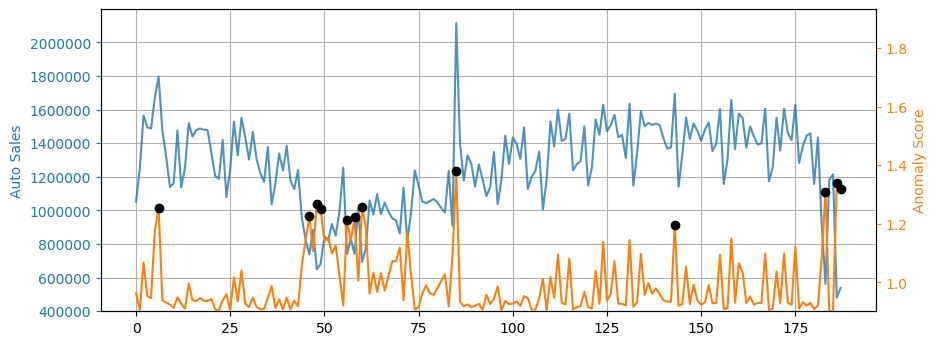

In [24]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [25]:
# SDK 2.0
rcf_inference.delete_endpoint()

# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in a taxi ridership dataset. In these data the anomalies occurred when ridership was uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as the NYC taxi dataset used above. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [26]:
df.head()

,timestamp,value,score
0,2005-01-01,1052224.0,0.963209
1,2005-02-01,1244753.0,0.905506
2,2005-03-01,1564938.0,1.067976
3,2005-04-01,1493837.0,0.952731
4,2005-05-01,1488171.0,0.946701


In [27]:
import numpy as np

# made a minor correction. increased size by 1 as the original code was skipping last shingle
def shingle(data, shingle_size):
    num_data = len(data)
    # +1
    shingled_data = np.zeros((num_data-shingle_size+1, shingle_size))
    
    # +1
    for n in range(num_data - shingle_size+1):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

In [28]:
# single data with shingle size=3 (one quarter - 3 months)
# let's try one year auto sales
# let's try 1 quarter window
shingle_size = 3
prefix_shingled = 'sagemaker/randomcutforest_shingled'
auto_data_shingled = shingle(df.values[:,1], shingle_size)

In [29]:
df.values[:5,1]

array([1052224.0, 1244753.0, 1564938.0, 1493837.0, 1488171.0],
      dtype=object)

In [30]:
shingle(df.values[:5,1],2)

array([[1052224., 1244753.],
       [1244753., 1564938.],
       [1564938., 1493837.],
       [1493837., 1488171.]])

In [31]:
auto_data_shingled[:5]

array([[1052224., 1244753., 1564938.],
       [1244753., 1564938., 1493837.],
       [1564938., 1493837., 1488171.],
       [1493837., 1488171., 1671401.],
       [1488171., 1671401., 1795944.]])

In [32]:
auto_data_shingled[-5:]

array([[1434716.,  912800.,  563122.],
       [ 912800.,  563122., 1181756.],
       [ 563122., 1181756., 1214706.],
       [1181756., 1214706.,  481587.],
       [1214706.,  481587.,  538854.]])

In [33]:
auto_data_shingled.shape

(186, 3)

We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [34]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      instance_count=1,
                      instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=48,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(auto_data_shingled))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-20 03:44:29 Starting - Starting the training job...
2020-11-20 03:44:35 Starting - Launching requested ML instances.........
2020-11-20 03:46:10 Starting - Preparing the instances for training......
2020-11-20 03:47:29 Downloading - Downloading input data...
2020-11-20 03:47:53 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[11/20/2020 03:48:16 INFO 140220173686592] Reading default configuration from /opt/amazon/lib/python2.7/site-pa


2020-11-20 03:48:22 Uploading - Uploading generated training model[11/20/2020 03:48:17 INFO 140220173686592] Cluster sharing facilities started.
[11/20/2020 03:48:17 INFO 140220173686592] Verifying all workers are accessible...
[11/20/2020 03:48:17 INFO 140220173686592] All workers accessible.
[11/20/2020 03:48:17 INFO 140220173686592] Initializing Sampler...
[11/20/2020 03:48:17 INFO 140220173686592] Sampler correctly initialized.
#metrics {"Metrics": {"initialize.time": {"count": 1, "max": 813.0438327789307, "sum": 813.0438327789307, "min": 813.0438327789307}}, "EndTime": 1605844097.264132, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1605844096.447857}

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Tot

In [35]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2020-11-20-03-44-29-640


In [36]:
rcf.hyperparameters()

{'num_samples_per_tree': '48',
 'num_trees': '50',
 'feature_dim': '3',
 'mini_batch_size': '1000'}

In [37]:
# SDK 2.0 serializers
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------------!

Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [38]:
# Score the shingled datapoints
results = rcf_inference.predict(auto_data_shingled)
scores = np.array([datum['score'] for datum in results['scores']])

In [39]:
# Save the scores
np.savetxt("scores_shingle_quarterly.csv",
           np.asarray(scores),
           delimiter=",",
           fmt='%10.5f')

In [40]:
# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 2.0*score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

[1.23970479 1.237306   1.24243529 1.20113952 1.20688003 1.20364666
 1.21591867 1.27179364 1.25965801 1.23695368 1.2269886  1.21157899
 1.28787972]


In [41]:
score_mean, score_std, score_cutoff

(1.0399478216096776, 0.08021324714910658, 1.2003743159078908)

In [42]:
scores

array([1.05886409, 1.01309795, 1.00321947, 1.08122594, 1.17285642,
       1.17027859, 1.11850573, 0.99330421, 0.99726166, 1.00487333,
       1.0157471 , 1.02413303, 0.99502544, 0.99260404, 0.96842788,
       0.95526873, 0.95093378, 0.95033657, 0.97468837, 0.97415134,
       0.96298882, 0.96503015, 1.01073685, 1.03013311, 1.02310153,
       0.99687684, 1.00796261, 1.00665111, 0.99605581, 0.95686933,
       0.9816373 , 0.96762788, 0.95340678, 0.96184484, 1.01411927,
       1.04638258, 1.01304984, 0.95115945, 0.96785929, 0.95381719,
       1.00754189, 0.966919  , 1.04327624, 1.11392179, 1.17215066,
       1.18885777, 1.23970479, 1.237306  , 1.24243529, 1.20113952,
       1.16667366, 1.15620156, 1.1229078 , 1.1291392 , 1.15315191,
       1.17507217, 1.20688003, 1.1885851 , 1.20364666, 1.19588219,
       1.21591867, 1.13313791, 1.04420074, 1.05519579, 1.04633805,
       1.05072272, 1.05553629, 1.08233823, 1.12792598, 1.1264922 ,
       1.14061377, 1.11131568, 1.13918382, 1.0252977 , 0.98450

In [43]:
anomalies.size

13

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

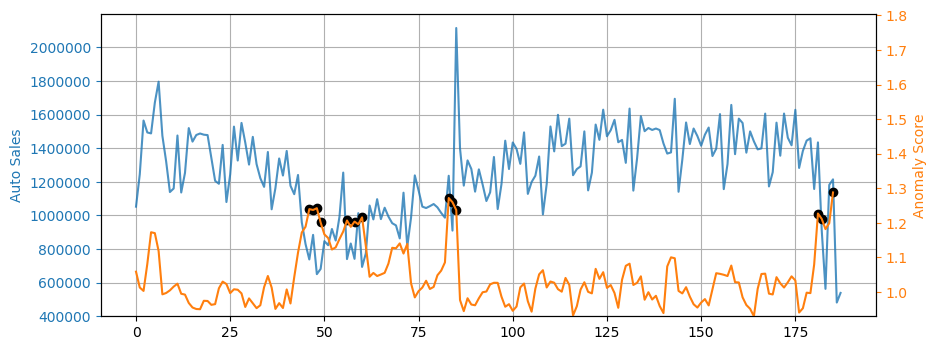

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(df)
taxi_data_subset = df[start:end]

ax1.plot(df['value'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')
ax2.scatter(anomaly_indices, anomalies, color='k')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Auto Sales', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

We see that with this particular shingle size, hyperparameter selection, and anomaly cutoff threshold that the shingled approach more clearly captures the major anomalous events: the spike at around t=6000 and the dips at around t=9000 and t=10000. In general, the number of trees, sample size, and anomaly score cutoff are all parameters that a data scientist may need experiment with in order to achieve desired results. The use of a labeled test dataset allows the used to obtain common accuracy metrics for anomaly detection algorithms. For more information about Amazon SageMaker Random Cut Forest see the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

In [45]:
# SDK 2.0

rcf_inference.delete_endpoint()